### Notebook Information

#### MobileNet V2 model on CIFAR 100 dataset to save a pickle file and later use it for transfer learning on CIFAR10 dataset in another notebook

In [1]:
# Importing the Required libraries for this Project
import numpy as np
import torch
import torch.nn as nn

In [2]:
# Setting the device 
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

First training on CIFAR100

In [3]:
from numpy.lib.shape_base import dstack
# Getting the Dataset from the datasets library

from torchvision import datasets as ds
from torchvision import transforms as tfs
from torch.utils.data.sampler import SubsetRandomSampler

# Creating a function to load our data and passing all the required parameters

def load_data_project(dataAddr, bs1, vs=0.1, shuffle=True, test=False):  
    nrm = tfs.Normalize(mean=[0.4913, 0.4821, 0.4465],std=[0.2470, 0.2435, 0.2615],)

    # use torchvision transforms on the data
    tf = tfs.Compose([tfs.Resize((224,224)), tfs.ToTensor(), nrm,])

    # If we are trying to load the test dataset
    if test == True:
        dsCurr = ds.CIFAR100(root=dataAddr, train=False,download=True,transform=tf,)

        load_data_project = torch.utils.data.DataLoader(dsCurr, batch_size=bs1, shuffle=shuffle)

        return load_data_project

    # load the dataset into train and validation variables
    dsCurrTrain = ds.CIFAR100(root=dataAddr, train=True, download=True, transform=tf,)

    dsCurrValid = ds.CIFAR100(root=dataAddr, train=True, download=True, transform=tf, )

    x = len(dsCurrTrain)
    positions = list(range(x))
    div = int(np.floor(vs * x))

    # To check and shuffle data accordingly
    if shuffle == True:
        np.random.seed(42)
        np.random.shuffle(positions)

    train_idx, valid_idx = positions[div:], positions[:div]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    trainLoaderCurr = torch.utils.data.DataLoader(dsCurrTrain, batch_size=bs1, sampler=train_sampler)
    validLoaderCurr = torch.utils.data.DataLoader(dsCurrValid, batch_size=bs1, sampler=valid_sampler)
    return (trainLoaderCurr, validLoaderCurr)
 
train_loader, valid_loader = load_data_project('./data',64)

test_loader = load_data_project('./data',64,test=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes_cifar = 100
epochs = 25
batch_size = 16
lr_eta = 0.1

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
model.classifier[1] = nn.Linear(1280, 100)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optim_func = torch.optim.SGD(model.parameters(), lr=lr_eta, weight_decay = 0.001, momentum = 0.9)  
steps = len(train_loader)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [6]:
import gc
steps = len(train_loader)

intermidiate_cost_history = []
inter_rights_history = []
val_intermidiate_cost_history = []
val_intermidiate_correct_cost_history = []

for temp in range(epochs):

    inter_cost = 0.0
    inter_rights = 0.0
    val_inter_cost = 0.0
    val_inter_rights = 0.0 

    for i, (imgs, lbls) in enumerate(train_loader):
        # Move tensors to the configured device
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        
        # Forward pass
        model_output = model(imgs)
        loss = loss_func(model_output, lbls)
        # print("Loss -")
        # print(loss)
        # print("Labels -")
        # print(labels)
        # Backward and optimize
        optim_func.zero_grad()
        loss.backward()
        optim_func.step()
        _, preds = torch.max(model_output, 1) # taking the highest value of prediction.
        inter_cost += loss.item()
        inter_rights += torch.sum(preds == lbls.data)

        del imgs, lbls, model_output
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch number [{}], the loss is: {:.4f}'.format(temp+1, loss.item()))
            
    # Validation
    with torch.no_grad():
        rights = 0
        all = 0
        for imgs, lbls in valid_loader:
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            model_output = model(imgs)
            _, predicted = torch.max(model_output.data, 1)
            all += lbls.size(0)
            rights += (predicted == lbls).sum().item()
            val_cost = loss_func(model_output, lbls)
            _, val_predictions = torch.max(model_output, 1)
            val_inter_cost += val_cost.item()
            val_inter_rights += torch.sum(val_predictions == lbls.data)
            del imgs, lbls, model_output
    
        print('Accuracy on {} Validation images is: {} %'.format(5000, 100 * rights / all)) 

    epoch_cost = inter_cost/len(train_loader) # loss per epoch
    epoch_acc = inter_rights.float()/ len(train_loader) # accuracy per epoch
    epoch_acc.to(device)
    intermidiate_cost_history.append(epoch_cost) # appending for displaying 
    inter_rights_history.append(epoch_acc)
    
    val_epoch_cost = val_inter_cost/len(valid_loader)
    val_epoch_acc = val_inter_rights.float()/ len(valid_loader)
    val_intermidiate_cost_history.append(val_epoch_cost)
    val_intermidiate_correct_cost_history.append(val_epoch_acc)

Epoch number [1], the loss is: 3.4734
Accuracy on 5000 Validation images is: 13.58 %
Epoch number [2], the loss is: 2.9920
Accuracy on 5000 Validation images is: 23.16 %
Epoch number [3], the loss is: 3.2832
Accuracy on 5000 Validation images is: 18.18 %
Epoch number [4], the loss is: 3.3733
Accuracy on 5000 Validation images is: 27.86 %
Epoch number [5], the loss is: 3.1545
Accuracy on 5000 Validation images is: 30.48 %
Epoch number [6], the loss is: 2.5822
Accuracy on 5000 Validation images is: 30.6 %
Epoch number [7], the loss is: 2.2881
Accuracy on 5000 Validation images is: 32.32 %
Epoch number [8], the loss is: 3.1403
Accuracy on 5000 Validation images is: 32.1 %
Epoch number [9], the loss is: 2.7333
Accuracy on 5000 Validation images is: 18.82 %
Epoch number [10], the loss is: 2.6515
Accuracy on 5000 Validation images is: 30.36 %
Epoch number [11], the loss is: 2.6837
Accuracy on 5000 Validation images is: 31.96 %
Epoch number [12], the loss is: 3.6125
Accuracy on 5000 Validatio

In [7]:
acc_history = []
type(inter_rights_history)
for i in inter_rights_history:
  acc_history.append(i.item())
val_history = []
for i in val_intermidiate_correct_cost_history:
  val_history.append(i.item())

In [8]:
intermidiate_cost_history

[3.9529645778238773,
 3.2654555290937424,
 2.887046559967778,
 2.7394227907061577,
 2.6636468422683803,
 2.644680505449122,
 2.5762017464095894,
 2.547253655777736,
 2.5359716694802046,
 2.5440281472084196,
 2.5445941134609957,
 2.547537599774924,
 2.548899696631865,
 2.5630017180334437,
 2.6924430704252287,
 2.6479631855406542,
 2.7069200323047964,
 2.705816065723246,
 2.646571784195575,
 2.6499717205085536,
 2.650208769704808,
 2.640497037632899,
 2.647990891879255,
 2.658237853849476,
 2.7500283772295173]

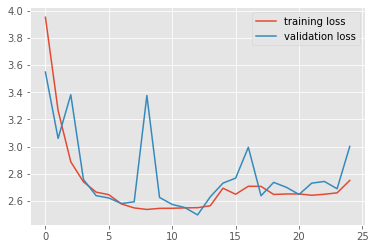

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(intermidiate_cost_history, label='training loss')
plt.plot(val_intermidiate_cost_history, label='validation loss')
plt.legend()

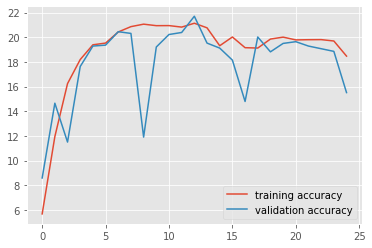

In [10]:
plt.style.use('ggplot')
plt.plot(acc_history, label='training accuracy')
plt.plot(val_history, label='validation accuracy')
plt.legend()

In [11]:
torch.save(model.state_dict(), 'model_save.pt')

In [12]:
with torch.no_grad():
    rights = 0
    all = 0
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        model_output = model(imgs)
        _, predicted = torch.max(model_output.data, 1)
        all += lbls.size(0)
        rights += (predicted == lbls).sum().item()
        del imgs, lbls, model_output

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * rights / all))   

Accuracy of the network on the 10000 test images: 24.92 %


Downloading pickle file for cifar100 based model to use later (like a checkpoint if session stops)

In [15]:
import pickle
with open('mobilenet_cifar100.pickle', 'wb') as f:
    pickle.dump(model, f)

from google.colab import files
files.download('mobilenet_cifar100.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

From here we upload the pickle file trained earlier in this notebook to retrieve cifar100 based model and we change a few layers but preserve the weights earlier to get the output for cifar10 model

Loading cifar 10 

In [16]:
from numpy.lib.shape_base import dstack
# Getting the Dataset from the datasets library

from torchvision import datasets as ds
from torchvision import transforms as tfs
from torch.utils.data.sampler import SubsetRandomSampler

# Creating a function to load our data and passing all the required parameters

def load_data_project(dataAddr, bs1, vs=0.1, shuffle=True, test=False):  
    nrm = tfs.Normalize(mean=[0.4913, 0.4821, 0.4465],std=[0.2470, 0.2435, 0.2615],)

    # use torchvision transforms on the data
    tf = tfs.Compose([tfs.Resize((224,224)), tfs.ToTensor(), nrm,])

    # If we are trying to load the test dataset
    if test == True:
        dsCurr = ds.CIFAR10(root=dataAddr, train=False,download=True,transform=tf,)

        load_data_project = torch.utils.data.DataLoader(dsCurr, batch_size=bs1, shuffle=shuffle)

        return load_data_project

    # load the dataset into train and validation variables
    dsCurrTrain = ds.CIFAR10(root=dataAddr, train=True, download=True, transform=tf,)

    dsCurrValid = ds.CIFAR10(root=dataAddr, train=True, download=True, transform=tf, )

    x = len(dsCurrTrain)
    positions = list(range(x))
    div = int(np.floor(vs * x))

    # To check and shuffle data accordingly
    if shuffle == True:
        np.random.seed(42)
        np.random.shuffle(positions)

    train_idx, valid_idx = positions[div:], positions[:div]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    trainLoaderCurr = torch.utils.data.DataLoader(dsCurrTrain, batch_size=bs1, sampler=train_sampler)
    validLoaderCurr = torch.utils.data.DataLoader(dsCurrValid, batch_size=bs1, sampler=valid_sampler)
    return (trainLoaderCurr, validLoaderCurr)
 
train_loader, valid_loader = load_data_project('./data',64)

test_loader = load_data_project('./data',64,test=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [17]:
from google.colab import files
import pickle

uploaded_files = files.upload()
f = list(uploaded_files.values())[0]
model_cifar10 = pickle.loads(f)
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
model.classifier[1] = nn.Linear(1280, 100)

Saving mobilenet_cifar100 (1).pickle to mobilenet_cifar100 (1).pickle


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
#loading weights from model_cifar10 and freezing them to only change the classifier from 10 to 100 and just train that part
model.load_state_dict(model_cifar10.state_dict())
model.classifier[1] = nn.Linear(1280, 10)
#using pre-trained weights from cifar100 model and unfreezing only last 4 blocks
for para in model.parameters():
  para.requires_grad = False
for para in model.features[14].parameters():
    para.requires_grad = True
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [19]:
classes_cifar = 10
epochs = 15
batch_size = 16
lr_eta = 0.1

model.classifier[1] = nn.Linear(1280, 10)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr_eta, weight_decay = 0.001, momentum = 0.9)  
total_step = len(train_loader)

In [20]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [21]:
import gc
steps = len(train_loader)

intermidiate_cost_history = []
inter_rights_history = []
val_intermidiate_cost_history = []
val_intermidiate_correct_cost_history = []

for temp in range(epochs):

    inter_cost = 0.0
    inter_rights = 0.0
    val_inter_cost = 0.0
    val_inter_rights = 0.0 

    for i, (imgs, lbls) in enumerate(train_loader):
        # Move tensors to the configured device
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        
        # Forward pass
        model_output = model(imgs)
        loss = loss_func(model_output, lbls)
        # print("Loss -")
        # print(loss)
        # print("Labels -")
        # print(labels)
        # Backward and optimize
        optim_func.zero_grad()
        loss.backward()
        optim_func.step()
        _, preds = torch.max(model_output, 1) # taking the highest value of prediction.
        inter_cost += loss.item()
        inter_rights += torch.sum(preds == lbls.data)

        del imgs, lbls, model_output
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch number [{}], the loss is: {:.4f}'.format(temp+1, loss.item()))
            
    # Validation
    with torch.no_grad():
        rights = 0
        all = 0
        for imgs, lbls in valid_loader:
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            model_output = model(imgs)
            _, predicted = torch.max(model_output.data, 1)
            all += lbls.size(0)
            rights += (predicted == lbls).sum().item()
            val_cost = loss_func(model_output, lbls)
            _, val_predictions = torch.max(model_output, 1)
            val_inter_cost += val_cost.item()
            val_inter_rights += torch.sum(val_predictions == lbls.data)
            del imgs, lbls, model_output
    
        print('Accuracy on {} Validation images is: {} %'.format(5000, 100 * rights / all)) 

    epoch_cost = inter_cost/len(train_loader) # loss per epoch
    epoch_acc = inter_rights.float()/ len(train_loader) # accuracy per epoch
    epoch_acc.to(device)
    intermidiate_cost_history.append(epoch_cost) # appending for displaying 
    inter_rights_history.append(epoch_acc)
    
    val_epoch_cost = val_inter_cost/len(valid_loader)
    val_epoch_acc = val_inter_rights.float()/ len(valid_loader)
    val_intermidiate_cost_history.append(val_epoch_cost)
    val_intermidiate_correct_cost_history.append(val_epoch_acc)

Epoch number [1], the loss is: 2.2751
Accuracy on 5000 Validation images is: 10.32 %
Epoch number [2], the loss is: 2.3426
Accuracy on 5000 Validation images is: 9.4 %
Epoch number [3], the loss is: 2.3485
Accuracy on 5000 Validation images is: 9.48 %
Epoch number [4], the loss is: 2.2835
Accuracy on 5000 Validation images is: 9.44 %
Epoch number [5], the loss is: 2.2895
Accuracy on 5000 Validation images is: 10.54 %
Epoch number [6], the loss is: 2.2712
Accuracy on 5000 Validation images is: 9.3 %
Epoch number [7], the loss is: 2.3313
Accuracy on 5000 Validation images is: 9.94 %
Epoch number [8], the loss is: 2.3127
Accuracy on 5000 Validation images is: 9.68 %
Epoch number [9], the loss is: 2.3082
Accuracy on 5000 Validation images is: 9.76 %
Epoch number [10], the loss is: 2.2466
Accuracy on 5000 Validation images is: 9.98 %
Epoch number [11], the loss is: 2.2836
Accuracy on 5000 Validation images is: 9.34 %
Epoch number [12], the loss is: 2.3362
Accuracy on 5000 Validation images 

In [22]:
acc_history = []
type(inter_rights_history)
for i in inter_rights_history:
  acc_history.append(i.item())
val_history = []
for i in val_intermidiate_correct_cost_history:
  val_history.append(i.item())

In [23]:
intermidiate_cost_history

[2.30361078476364,
 2.3037554821507498,
 2.3034893419932234,
 2.3033522316678003,
 2.3034935217689383,
 2.304009211334315,
 2.3036384426734666,
 2.3037160756913098,
 2.3041816848245533,
 2.3034161170097915,
 2.3039165884256363,
 2.30362336168235,
 2.303714548999613,
 2.304019217125394,
 2.3033658753741872]

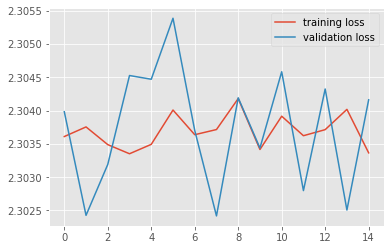

In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(intermidiate_cost_history, label='training loss')
plt.plot(val_intermidiate_cost_history, label='validation loss')
plt.legend()

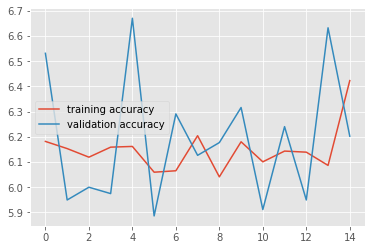

In [25]:
plt.style.use('ggplot')
plt.plot(acc_history, label='training accuracy')
plt.plot(val_history, label='validation accuracy')
plt.legend()

In [26]:
torch.save(model.state_dict(), 'model_save2.pt')

In [27]:
with torch.no_grad():
    rights = 0
    all = 0
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        model_output = model(imgs)
        _, predicted = torch.max(model_output.data, 1)
        all += lbls.size(0)
        rights += (predicted == lbls).sum().item()
        del imgs, lbls, model_output

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * rights / all))   

Accuracy of the network on the 10000 test images: 9.98 %
